In [ ]:
import autograd.numpy as np
from autograd import grad 
import autograd.numpy.random as npr
from torch.autograd import Variable
import torch
import torch.optim as optim

from autograd.core import primitive
import tensorflow as tf
import math as mat

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
nx = 50
dx = 1. / nx
nt = 50
dt = 1. / nt
# W = [npr.randn(1, 10), npr.randn(10, 1)]
x_space = Variable(torch.linspace(0, 2, nx),requires_grad=False)
t_space = Variable(torch.linspace(0, 2, nt),requires_grad=False)

In [ ]:
# The initial values for the variables
inf_s = 1e-4
y_0 = 1
# here k= rs/2 = GM/c^2
k = 1
# initial value of particle's position (here it is 6*rs {Where rs is the schwarzschild Radius})
r_0 = 6
# here e => specific energy
e = 0.9741
#l=> specific angular momentum
l = 3.7977


# l = 3.46
# l = 8.485*k
# e = 0.94


# Sigmoid  activation function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# sigmoid derivative
def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))


# tanh derivative
def tanh_grad(x):
    return 4/(torch.exp(x)+torch.exp(-x))**2

# tanh activation function
def tanh(x):
    return (torch.exp(x) - torch.exp(-x))/(torch.exp(x) + torch.exp(-x))


# LeakyReLU activation
def leakyReLU(x):
  return torch.where(x > 0.0, x, x * 0.01)

# Leaky ReLU derivative
def leakyReLU_grad(x):
  return torch.where(x > 0.0, 1.0, 0.01)


# This function constructs a three layered neural network with 1 input layer and one output layer (ex: NN_x(t) and NN_y(t)) and tanh activation
def neural_network(W, mat_input, b):
     a1 = tanh(torch.mm(mat_input, W[0]) + b[0])
     a2 = tanh(torch.mm(a1, W[1] + b[1]))
     return torch.dot(torch.flatten(torch.transpose(a2,0,1)), torch.flatten(W[2]))


# derivative of NN analytical with tanh activation
#def d_neural_network_dx(W, x, b, k=1):
 #   return torch.dot(torch.flatten(tanh_grad(torch.mul(W[0],x) + b)) , torch.flatten(torch.transpose(W[0],0,1).mul(W[1])))



# This function constructs a three layered neural network with 1 input layer and one output layer (ex: NN_x(t) and NN_y(t)) and sigmoid activation
# def neural_network(W, x, b):
#      a1 = sigmoid(torch.mul(W[0],x) + b)
#      return torch.dot(torch.flatten(a1), torch.flatten(W[1]))


# This function takes the derivative of Neural Network output w.r.t 'x'
#d/dx
def d_neural_network_dx(W, mat_input, k=1):
    inf_tensor = torch.Tensor([[inf_s, 0]]).float()
    mat_input_ad = mat_input + inf_tensor
    return (neural_network(W, mat_input_ad, b) - neural_network(W, mat_input, b))/inf_s

#d/dt
def d_neural_network_dt(W, mat_input, k=1):
    inf_tensor = torch.Tensor([[0, inf_s]]).float()
    mat_input_ad = mat_input + inf_tensor
    return (neural_network(W, mat_input_ad, b) - neural_network(W, mat_input, b))/inf_s

#d2/dx2
def d_neural_network_dxx(W, mat_input, b, k=1):
    inf_tensor = torch.Tensor([[inf_s, 0]]).float()
    mat_input_ad = mat_input + inf_tensor
    return (d_neural_network_dx(W, mat_input_ad, b) - d_neural_network_dx(W, mat_input, b))/inf_s

#d2/dt2
def d_neural_network_dtt(W, mat_input, b, k=1):
    inf_tensor = torch.Tensor([[0, inf_s]]).float()
    mat_input_ad = mat_input + inf_tensor
    return (d_neural_network_dt(W, mat_input_ad, b) - d_neural_network_dt(W, mat_input, b))/inf_s

# d2/dxdt
def d_neural_network_dtx(W, mat_input, b, k=1):
    inf_tensor = torch.Tensor([[inf_s, 0]]).float()
    mat_input_ad = mat_input + inf_tensor
    return (d_neural_network_dt(W, mat_input_ad, b) - d_neural_network_dt(W, mat_input, b))/inf_s

#d2/dtdx
def d_neural_network_dxt(W, mat_input, b, k=1):
    inf_tensor = torch.Tensor([[0, inf_s]]).float()
    mat_input_ad = mat_input + inf_tensor
    return (d_neural_network_dx(W, mat_input_ad) - d_neural_network_dx(W, mat_input))/inf_s




In [ ]:
def err_boundaryCond(Xi,Ti,W,b):
  return (neural_network(W, torch.Tensor([[Xi,0]]).float(), b) - Xi)**2 

def err_boundaryCond1(Xi,Ti,W,b):
  return (neural_network(W, torch.Tensor([[Xi,0]]).float(), b) + np.sin(np.pi*Xi))**2

def err_boundaryCond2(Xi,Ti,W,b):
  return (neural_network(W, torch.Tensor([[-1,Ti]]).float(), b))**2

def err_boundaryCond3(Xi,Ti,W,b):
  return (neural_network(W, torch.Tensor([[1,Ti]]).float(), b))**2

# def get_errSqr(net_out, d_net_out_t, d_net_out_x):
#     return (d_net_out_t + net_out*d_net_out_x)**2

def get_errSqr(u, du_t, du_x):
  return (du_t + u*du_x)**2


In [ ]:
def loss_function(W, T, X, epoch, b):
    loss_sum = 0.
    for Ti in T:
      for Xi in X:
        mat_input = torch.tensor([[Xi,Ti]]).float()
        # mat_input = torch.tensor(mat_input)
        #print(mat_input.type())
        #W_t = W[0]
        #W_r = W[1]
        #W_fi = W[2]
        net_out = neural_network(W, mat_input, b)
        u = Ti*net_out + Xi
        # net_out_r = neural_network(W_r, Ti, b[1][0])
        # net_out_fi = neural_network(W_fi, Ti, b[2][0])
        # # y_t = y_0 + (xi+1) * net_out
        # t_T = Ti*net_out_t
        # # r_T = r_0 + (Ti**2)*net_out_r
        # r_T = r_0 + Ti*net_out_r
        # fi_T = Ti*net_out_fi
        d_net_out_x = d_neural_network_dx(W, mat_input, b)
        d_net_out_t = d_neural_network_dt(W, mat_input, b)

        du_t = net_out + Ti*d_net_out_t
        du_x = Ti*d_net_out_x + 1
        err = err_boundaryCond(Xi,Ti,W,b)
        #err1 = err_boundaryCond1(Xi,Ti,W,b)
        #err2 = err_boundaryCond2(Xi,Ti,W,b)
        #err3 = err_boundaryCond3(Xi,Ti,W,b)
        #err_eq = get_errSqr(net_out, d_net_out_t, d_net_out_x)
        err_eq = get_errSqr(u, du_t, du_x)
        #err_eq = get_errSqr(net_out, d_net_out_t, d_net_out_x, d_net_out_xx)
        err_sqr = err_eq + err
      
        loss_sum += err_eq
    print("epoch-->>",epoch, loss_sum)
    return loss_sum

In [ ]:
W = [Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(2+20)), size = (2,20))).float(), requires_grad=True),
     Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(20+20)), size = (20,20))).float(), requires_grad=True), 
     Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(20+1)), size = (20,1))).float(), requires_grad=True)]
b = [Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(1+20)), size = (1,20))).float(), requires_grad=True),
     Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(1+20)), size = (1,20))).float(), requires_grad=True)]

print(b[0].type())
# W_r = [Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(1+20)), size = (1,20))), requires_grad=True), Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(20+1)), size = (20,1))), requires_grad=True)]
# b_r = [Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(1+20)), size = (1,20))), requires_grad=True)]
# W_fi = [Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(1+20)), size = (1,20))), requires_grad=True), Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(20+1)), size = (20,1))), requires_grad=True)]
# b_fi = [Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(1+20)), size = (1,20))), requires_grad=True)]

# W = [W_t,W_r,W_fi]
# b = [b_t,b_r,b_fi]

# W = [W_t,W_r,W_fi]
# b = [b_t,b_r,b_fi]

# x = np.array(1)
# print neural_network(W, x)
# print d_neural_network_dx(W, x)

# optimizer = optim.Adam([W[0][0], W[0][1], W[1][0], W[1][1], W[2][0], W[2][1], b[0][0], b[1][0], b[2][0]], lr=0.000001)

optimizer = optim.Adam([W[0], W[1], b[0]], lr=0.1)

#optimizer = optim.Adam([W[0][0], W[0][1], W[1][0], W[1][1], W[2][0], W[2][1], b[0][0], b[1][0], b[2][0]], lr=0.01)

for i in range(500):
    
    optimizer.zero_grad()
    loss = loss_function(W, t_space, x_space, i, b)

    # This function will calculate the gradient of loss function w.r.t all the weights for which the requires_grad is set to true
    # and save the calculated gradient in w[i].grad.data where w[i] is the ith weight in the weight array 

    loss.backward()


    optimizer.step()
    # Setting the grad.data to zero before next iteration because otherwise it will add the grad to prev value
    W[0].grad.data.zero_()
    W[1].grad.data.zero_()
    W[2].grad.data.zero_()
    b[0].grad.data.zero_()
    b[1].grad.data.zero_()


torch.FloatTensor
epoch-->> 0 tensor(8794.8994, grad_fn=<AddBackward0>)
epoch-->> 1 tensor(22641.0098, grad_fn=<AddBackward0>)
epoch-->> 2 tensor(11851.3320, grad_fn=<AddBackward0>)
epoch-->> 3 tensor(3465.0847, grad_fn=<AddBackward0>)
epoch-->> 4 tensor(2068.6187, grad_fn=<AddBackward0>)
epoch-->> 5 tensor(1564.8303, grad_fn=<AddBackward0>)
epoch-->> 6 tensor(3503.9453, grad_fn=<AddBackward0>)
epoch-->> 7 tensor(2516.2161, grad_fn=<AddBackward0>)
epoch-->> 8 tensor(1022.0297, grad_fn=<AddBackward0>)
epoch-->> 9 tensor(679.5094, grad_fn=<AddBackward0>)
epoch-->> 10 tensor(727.7034, grad_fn=<AddBackward0>)
epoch-->> 11 tensor(619.2417, grad_fn=<AddBackward0>)
epoch-->> 12 tensor(540.2626, grad_fn=<AddBackward0>)
epoch-->> 13 tensor(658.1882, grad_fn=<AddBackward0>)
epoch-->> 14 tensor(784.8987, grad_fn=<AddBackward0>)
epoch-->> 15 tensor(821.5579, grad_fn=<AddBackward0>)
epoch-->> 16 tensor(760.3861, grad_fn=<AddBackward0>)
epoch-->> 17 tensor(608.8301, grad_fn=<AddBackward0>)
epoch-->>

In [ ]:
torch.save(W, 'W_save.pt')
torch.save(b, 'b_save.pt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
W = torch.load('/content/drive/My Drive/Weights and biases/W_save.pt')
b = torch.load('/content/drive/My Drive/Weights and biases/b_save.pt')

Mounted at /content/drive


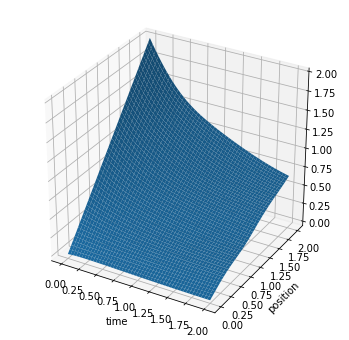

In [ ]:
res = np.zeros((50,50))
i=0
j=0
for i in range(len(x_space)):
  for j in range(len(t_space)):
    res[i][j] = t_space[j]*neural_network(W, torch.Tensor([[x_space[i],t_space[j]]]).float(), b) + x_space[i]
    j = j+1
  i=i+1
    #print(res[i][j])

X,T = np.meshgrid(x_space,t_space)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')


ax.set_xlabel('time')
ax.set_ylabel('position')

# Plot a 3D surface
ax.plot_surface(X, T, res)


plt.show()

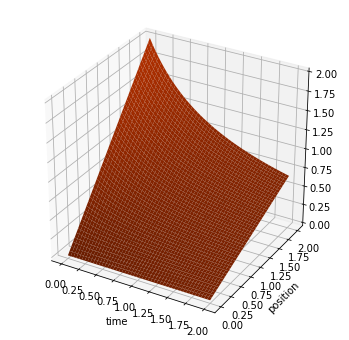

In [ ]:
t = np.linspace(0,2,50)
x = np.linspace(0,2,50)

X,T = np.meshgrid(x,t)

z = X/(T+1)


fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')


ax.set_xlabel('time')
ax.set_ylabel('position')

# Plot a 3D surface
ax.plot_surface(T, X, z, color='orangered')

t=0.5 sec


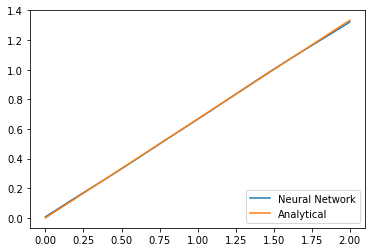

In [ ]:
import matplotlib.pyplot as plt
act_res = np.zeros(50)
pred_res = np.zeros(50)
print("t=0.5 sec")
for i in range(len(x_space)):
  pred_res[i] = 0.5*neural_network(W, torch.Tensor([[x_space[i],0.5]]).float(), b) + x_space[i]
  act_res[i] = x_space[i]/(1+0.5)

plt.plot(x,pred_res)
plt.plot(x,act_res)
plt.legend(["Neural Network", "Analytical"], loc ="lower right")